# Piglet Algorithm Trading Bot Development Project  

Last Updated : 2021/08/15
Editor : Jeong Kim

## Import Modules & Initialize Piglet Bot

In [1]:
#%% Import Modules

import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.cbook as cbook
import pymysql
import mplfinance as mpf
import seaborn as sns
from scipy.signal import savgol_filter
import pyupbit
import telegram
import requests
import time
import datetime as dt
import math
import urllib.request
import json
import codecs
import copy
import os
import IPython.display as IPydisplay
import re
from IPython.display import clear_output

from sys import exit
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)
clear_output(wait=True)

## Initialize Upbit API & Telegram & Website 

In [2]:
## Load API and accounts

host = 'leaderboard.cten39djs6f8.ap-northeast-2.rds.amazonaws.com'
username = 'admin'
password = 'comathon0123'
database = 'leaderboarddb'

db = pymysql.connect(host=host, user=username, password=password, database=database)
# cur = db.cursor()

## Make DataFrame containing all Users

df_users = pd.DataFrame(
    columns=['email', 'bot', 'access_key', 'secret_key', 'trade_amount'])

cur = db.cursor()

### EMAIL list
cur.execute("SELECT email FROM users")
emaillist = cur.fetchall()
emailstr = str(emaillist)
user_email = re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", emailstr)
# print(user_email)

# email = user_email[0]

#Loop through each user email
for email in user_email:
    # print(email)
    cur.execute("SELECT selectedbot FROM users WHERE email=%s", [email])
    selectedbot1 = cur.fetchone()
    selectedbot = selectedbot1[0]
    # print(selectedbot)

    ### APIKey
    cur.execute("SELECT apikey FROM users WHERE email=%s", [email])
    apikeyget = cur.fetchone()
    api = apikeyget[0]
    # print(api)

    ### SecretKey
    cur.execute("SELECT secretkey FROM users WHERE email=%s", [email])
    secretkeyget = cur.fetchone()
    secretkey = secretkeyget[0]
    # print(secretkey)

    ### 매수금액
    cur.execute("SELECT tradingamount FROM users WHERE email=%s", [email])
    trdamtget = cur.fetchone()
    trdamt = trdamtget[0]
    # print(trdamt)

    user = {'email': email, 'bot':selectedbot, 'access_key':api, 'secret_key':secretkey, 'trade_amount':trdamt}
    df_users = df_users.append(user, ignore_index = True)

cur.close()

# df_users

## Extract "piglet" bots
df_piglet = df_users[df_users['bot'] == 'piglet']
r, c = df_piglet.shape

# df_piglet

## Employ Dynamic Variable to access API
for n in range(0, r):
    globals()['Upbit%s' % n] = pyupbit.Upbit(df_piglet['access_key'].iloc[n],df_piglet['secret_key'].iloc[n])       


In [6]:
df_piglet

,email,bot,access_key,secret_key,trade_amount
1,davidyang322@gmail.com,piglet,WsycWJwWzRmxm5ft1KHTu90wgAn4P8KIYcL5owJd,PngaDlgIM5YuXDE8RpxmRSK3RkYdWwrfvTHF77K2,"10,000,000.00"
3,kptib88@gmail.com,piglet,YslQ84yyDYjrjGFbczWE7QHh7fx6iKN5KbsXITco,P6x9esjEGzVtzl2xNKtWkqy7PjMTCvEnTwjg8pa7,"5,000.00"
5,jeongkim0653@gmail.com,piglet,xoqKo6sl9YWTx9izmwnKMFR5Jfz3z2lOaB538US1,i8XemoynYHPNLO9atVbYfBl1J6A7oogqAKLoUzxv,0.00


In [42]:
#%% Load API and Telegram

def Upbit_API(name = ""):
    
    if name == 'Coma':
        
        # ## Load Upbit API (Jeong Kim)
        # access_key = "xoqKo6sl9YWTx9izmwnKMFR5Jfz3z2lOaB538US1"
        # secret_key = "i8XemoynYHPNLO9atVbYfBl1J6A7oogqAKLoUzxv"
        
        ## Load Upbit API (Jeong Kim, read and trade only)
        access_key = "AJBVx5tiPtTqKRzF2qjjzbTxgEImOHCx4XgRfQZk"
        secret_key = "F6WxSBXN2xOWONxoVBUxIn8Sq1t3NszuSnE1L6J7"       
    
    elif name == "Piglet":
        # Load Upbit API (돼령) : Home and Laptop
        access_key = "YslQ84yyDYjrjGFbczWE7QHh7fx6iKN5KbsXITco"
        secret_key = "P6x9esjEGzVtzl2xNKtWkqy7PjMTCvEnTwjg8pa7"
        
    else:        
        # Load Upbit API (돼령)
        access_key = "YslQ84yyDYjrjGFbczWE7QHh7fx6iKN5KbsXITco"
        secret_key = "P6x9esjEGzVtzl2xNKtWkqy7PjMTCvEnTwjg8pa7"

    
    upbit = pyupbit.Upbit(access_key, secret_key)  # API 로그인 함수 호출

    return upbit

In [4]:
## Load Telegram Bot
def load_telegram():
    ## Load Telegram Bot
    chat_id = "@Comathon_coma" #김정 Open Channel
    chat_id2 = "1041595364" # 김정 kptib88_bot (practice)
    
    token = '1017063622:AAG3GAU-mPyGFqpPN_MneEvLKoLMBH4BmqE' #김정

    bot = telegram.Bot(token) #Open Channel

#     bot.sendMessage(chat_id2, text ="COMA : Trading Bot Initiated")
#     bot.sendMessage(chat_id2, text = "COMA2 : Trading Bot Initiated")

    return bot

In [5]:
## Link with Comathon Website, Update Profits
def update_website(balance):    
    host = 'leaderboard.cten39djs6f8.ap-northeast-2.rds.amazonaws.com'
    username = 'admin'
    password = "comathon0123"    
    database = 'leaderboarddb'

    db = pymysql.connect(host=host, user=username, password=password, database=database)

    cursor = db.cursor()

    # UPDATE DATA
    profitvar = balance
    updateData = "UPDATE leaderboardTable SET profit = %s WHERE name= 'Piglet'"   ## 'CS Bot', 'Piglet'
    cursor.execute(updateData, (profitvar,))

    db.commit()

    # SHOW TABLE
    selectAll = "SELECT * FROM leaderboardTable ORDER BY profit"
    cursor.execute(selectAll)
    rows = cursor.fetchall()

    # for row in rows:
    #     print(row)

    db.close()
    
    return None



In [43]:
## Connect Upbit API

bot_name = 'Coma' #Coma or Piglet
upbit = Upbit_API(bot_name)
upbit2 = Upbit_API('Piglet') 

## Load Telegram Bot
bot = load_telegram()

activate_bot = True

chat_id = "@Comathon_coma" #김정 Open Channel
chat_id2 = "1041595364" # 김정 kptib88_bot

if activate_bot:
    bot.sendMessage(chat_id, text =f"{bot_name} : Telegram Bot Activated")


In [44]:
upbit.get_balances()

[{'currency': 'KRW',
  'balance': '0.63411881',
  'locked': '0.0',
  'avg_buy_price': '0',
  'avg_buy_price_modified': True,
  'unit_currency': 'KRW'},
 {'currency': 'BTC',
  'balance': '0.00000001',
  'locked': '0.0',
  'avg_buy_price': '51972000',
  'avg_buy_price_modified': False,
  'unit_currency': 'KRW'},
 {'currency': 'XLM',
  'balance': '2341.03236246',
  'locked': '0.0',
  'avg_buy_price': '346',
  'avg_buy_price_modified': False,
  'unit_currency': 'KRW'},
 {'currency': 'TRX',
  'balance': '0.00000075',
  'locked': '0.0',
  'avg_buy_price': '121',
  'avg_buy_price_modified': False,
  'unit_currency': 'KRW'},
 {'currency': 'BTT',
  'balance': '210084033.61344312',
  'locked': '0.0',
  'avg_buy_price': '0.0048',
  'avg_buy_price_modified': False,
  'unit_currency': 'KRW'},
 {'currency': 'WIN',
  'balance': '116.59101432',
  'locked': '0.0',
  'avg_buy_price': '0',
  'avg_buy_price_modified': False,
  'unit_currency': 'KRW'},
 {'currency': 'MLK',
  'balance': '420.16806722',
  'l

In [7]:
# profit = -12
# update_website(profit)  ## updating comathon website

## UPBIT API (get balance, empty balance, data aquisition, buy and sell coin)

In [11]:
def get_current_price(ticker = 'KRW-BTC'):
    try:
        url = "https://api.upbit.com/v1/ticker"
        # headers = {"Accept": "application/json"}
        querystring = {"markets": ticker}
                
        response = requests.request("GET", url, params=querystring)
          
        # response = requests.get(url, params=querystring)
        ticker_data = response.json()
        time.sleep(0.1)
        return ticker_data[0]['trade_price']
    
    except:
        # print(f"{ticker[4:]} is not listed in KRW Market, SKIP")
        return None

In [60]:
def get_balance():
    ## Get My Upbit Balance, 이거 맨날 오류나는데 왜그러지?
    ## upbit.get_balance() 함수가 업데이트 되어서 [0] 부분을 제거해야함 -- done
    ## Split into two loops

    balance = upbit.get_balances()
    time.sleep(0.1)

    df_balance = pd.DataFrame(
        columns=['currency', 'balance', 'avg_buy_price', 'KRW_avg_buy_price', 'current_price', 'KRW_current_balance',
                 'Current_Profit(%)', 'KRW_total_balance', 'KRW_total_profit(%)'])
    pd.options.display.float_format = '{:,.2f}'.format
    
    df_balance['KRW_total_balance'] = np.nan
    df_balance['KRW_total_profit(%)'] = np.nan

    # Loop through each item in the balance
    for i in range(len(balance[0])):

        coin = balance[i] ## 
        # print(coin)
        
        ## If the item 'KRW', then skip
        if coin['currency'] == 'KRW':
            df_balance = df_balance.append(coin, ignore_index=True)
     
        else:
            coin['KRW_avg_buy_price'] = float(coin['balance']) * float(coin['avg_buy_price'])

            coin['current_price'] = get_current_price('KRW-' + coin['currency'])
            time.sleep(0.05)

            ## Many times current_price returns TypeError, this code handles it
            if coin['current_price'] == None:
                coin['KRW_current_balance'] = 1
                coin_name = coin['currency']

            else:
                coin['KRW_current_balance'] = float(coin['balance']) * float(coin['current_price'])

            ## Prevent division by zero
            if coin['KRW_avg_buy_price'] == None:
                coin['Current_profit(%)'] == np.nan

            else:
                try:
                    coin['Current_Profit(%)'] = (coin['KRW_current_balance'] - coin['KRW_avg_buy_price']) / coin[
                        'KRW_avg_buy_price'] * 100
                    df_balance = df_balance.append(coin, ignore_index=True)
                except:
                    continue

    df_upbit_balance = df_balance.copy(deep = True).drop(['avg_buy_price_modified', 'locked', 'unit_currency'], axis=1)
    

    return df_upbit_balance

In [61]:
get_balance()
# balance = upbit.get_balances()
# balance[3]

,currency,balance,avg_buy_price,KRW_avg_buy_price,current_price,KRW_current_balance,Current_Profit(%),KRW_total_balance,KRW_total_profit(%)
0,KRW,0.63411881,0,NaN,NaN,NaN,NaN,nan,nan
1,BTC,0.00000001,51972000,0.52,"47,216,000.00",0.47,-9.15,nan,nan
2,XLM,2341.03236246,346,"809,997.20",254.00,"594,622.22",-26.59,nan,nan
3,TRX,0.00000075,121,0.00,74.50,0.00,-38.43,nan,nan
4,BTT,210084033.61344312,0.0048,"1,008,403.36",0.00,"546,218.49",-45.83,nan,nan


In [13]:
# df_balance = get_balance()
# df_balance


In [14]:
#%%
def empty_balance():
    # Empty out all balances by going through each coin and calling market sell function

    df_balance = get_balance()

    for item in df_balance.currency:
        #     print(item)
        krw_ticker = 'KRW-' + item
        #     print(krw_ticker)
        if krw_ticker == 'KRW-KRW':
            #         print('KRW not sold')
            pass
        else:
            unit = upbit.get_balance(krw_ticker)
            time.sleep(0.1)
            sell_trade = upbit.sell_market_order(krw_ticker, unit)

    time.sleep(1)

    df_balance = get_balance()

    return df_balance



In [15]:
# empty_balance()

In [16]:
#%%
def get_KRW_total(df_balance):
    ## Calculate my total KRW balance

    KRW_total = 0
    for i in range(len(df_balance)):
        # print(i)
        if df_balance['currency'].iloc[i] == 'KRW':

            KRW_total += float(df_balance['balance'].iloc[i])

        else:
            KRW_total += float(df_balance['KRW_current_balance'].iloc[i])

    return KRW_total

In [17]:

def get_data(krw_ticker, from_date, interval, min_interval, update, count = 200):
    ## Get CLOSE price data and volume from UPBIT API
    ## krw_ticker : name of the ticker (ex: 'KRW-BTC')
    ## from_date : from the desired starting time (from_date) to now (current time). The "from_date" should be in the format of 'YYYY-MM-DD'
    ## Interval  : 'minutes', 'days', 'weeks', 'months'. If 'minutes', then also specify min_interval = 1, 3, 5, 15, 10, 3, 60, 240
    ## update : if update = True, then only call 10 datapoints
    ## Returns a Pandas dataframe (df_data)
    ## Change Required : I need to remove the data prior to "from_date" input

    krw_ticker = krw_ticker
    from_date = from_date
    interval = interval
    min_interval = min_interval  # 1, 3, 5, 15, 10, 30, 60, 240

    ## Set the right URL
    if interval == "minutes":
        url = "https://api.upbit.com/v1/candles/minutes/" + str(min_interval)

    else:
        url = "https://api.upbit.com/v1/candles/" + interval

    ## initiate empty dataframe
    df_data = pd.DataFrame(columns=['datetime', 'Open', 'High', 'Low', 'Close', 'Volume'])

    # Get the First Current Time and remove 'T'
    # querystring에서 "to"는 kst 시간이 아니고 utc 시간이므로 candle_date_time을 따로 저장해서 time_temp로 tracking해야함
    querystring = {"market": krw_ticker, "count": "1"}

    while True:
        try:
            response = requests.request("GET", url, params=querystring)
        except Exception as e:
            print(e)
            time.sleep(20)
            continue
        if str(response) == '<Response [200]>':
            break
        time.sleep(10)

    ticker_data = response.json()

    time_now_utc = ticker_data[0]['candle_date_time_utc']
    time_temp_utc = copy.deepcopy(time_now_utc)
    time_temp_utc = time_temp_utc.replace('T', ' ')

    time_now_kst = ticker_data[0]['candle_date_time_kst']
    time_temp_kst = copy.deepcopy(time_now_kst)
    time_temp_kst = time_temp_kst.replace('T', ' ')

    # Upbit API는 첫번째 index를 "to" date로 찾고 과거로 감. 따라서 현재시간을 call한 후 지정한 from_date로 갈때까지 Loop을 돌려야함
    # querystring에서 "to"는 kst 시간이 아니므로 candle_date_time을 따로 저장해서 time_temp로 tracking해야함

    if update == False:
        print('Processing....', time_temp_kst)
        while (1):

            if from_date < time_temp_utc:

                querystring = {"market": krw_ticker, "to": time_temp_utc, "count": "200"}

                while True:
                    try:
                        response = requests.request("GET", url, params=querystring)
                    except Exception as e:
                        print(e)
                        time.sleep(20)
                        continue
                    if str(response) == '<Response [200]>':
                        break
                    time.sleep(10)

                ticker_data = response.json()

                ## Reorganize the data into df_data format
                for i in range(len(ticker_data)):
                    price_dict = {'datetime': ticker_data[i]['candle_date_time_kst'].replace('T', ' '),
                                   'Open': ticker_data[i]['opening_price'],
                                   'High': ticker_data[i]['high_price'],
                                   'Low' : ticker_data[i]['low_price'],
                                  'Close': ticker_data[i]['trade_price'],
                                  'Volume': ticker_data[i]['candle_acc_trade_volume']}
                    df_data = df_data.append(price_dict, ignore_index=True)

                # Remove 'T' in the time data
                time_temp_utc = copy.deepcopy(ticker_data[i]['candle_date_time_utc'].replace('T', ' '))
                time_temp_kst = copy.deepcopy(ticker_data[i]['candle_date_time_kst'].replace('T', ' '))
                print('Processing....', time_temp_kst)

                time.sleep(0.1)
            else:
                break

    ## For data update, then just call recent 20 datapoints
    elif update == True:

        querystring = {"market": krw_ticker, "count": "20"}

        while True:
            try:
                response = requests.request("GET", url, params=querystring)
            except Exception as e:
                print(e)
                time.sleep(20)
                continue
            if str(response) == '<Response [200]>':
                break
            time.sleep(10)

        ticker_data = response.json()

        ## Reorganize the data into df_data format
        for i in range(len(ticker_data)):
            price_dict = {'datetime': ticker_data[i]['candle_date_time_kst'].replace('T', ' '),
                            'Open': ticker_data[i]['opening_price'],
                            'High': ticker_data[i]['high_price'],
                            'Low' : ticker_data[i]['low_price'],
                            'Close': ticker_data[i]['trade_price'],
                            'Volume': ticker_data[i]['candle_acc_trade_volume']}
            df_data = df_data.append(price_dict, ignore_index=True)

        # Remove 'T' in the time data
        time_temp_utc = copy.deepcopy(ticker_data[i]['candle_date_time_utc'].replace('T', ' '))
        time_temp_kst = copy.deepcopy(ticker_data[i]['candle_date_time_kst'].replace('T', ' '))
        #         print('Processing....', time_temp_kst)

        time.sleep(0.1)

    ## Need to reverse the order of the dataframe for MACD calculation
    ## Set .copy = Important to avoid SettingWithCopyWawrning (Problem persists with KRW-BTC for some reason)
    ## This code loses the last element?
    df_data_reverse = df_data.iloc[::-1].copy() 
    df_data_reverse = df_data_reverse.copy().reset_index()
    df_data_reverse = df_data_reverse.copy().drop(['index'], axis=1) 

    ## Change the time column (string) to datetime object (class) - Very Important
    for i in range(len(df_data_reverse.datetime)):
        dt_temp = df_data_reverse.datetime.iloc[i]
        temp = dt.datetime.strptime(dt_temp, '%Y-%m-%d %H:%M:%S')
        df_data_reverse.datetime.loc[i] = temp

    if update == False:
        clear_output(wait=True)
  
    # return df_data_reverse.set_index('datetime')
    return df_data_reverse

In [18]:
def append_data(df_data_old, df_data_update):
    ## Takes in on-going dataset and 20 recent datapoints
    ## Append recent data onto the existing df_data dataframe
    ## Maintain the same df size

    ## Loop through every updated item
    count = 0
    for i in range(len(df_data_update.datetime)):

        date = df_data_update.datetime.iloc[i]

        ## If the updated item is not in the old dataset, then append
        if date in df_data_old.values:
            pass
        elif date not in df_data_old.values:
            count += 1
            df_data_old = df_data_old.append(df_data_update.iloc[i])

    ## Cut out the Old Data & Reset Index
    df_data_new = df_data_old.copy(deep=True)
    df_data_new = df_data_new[count:].copy(deep = True)
    df_data_new.reset_index(drop=True, inplace=True)

    return df_data_new

In [19]:
def buy_coin(krw_ticker, buy_amount_won):  # Buy at Market Price 'KRW-ticker'

    #buy_price = pyupbit.get_current_price(krw_ticker)
    buy_trade = upbit.buy_market_order(krw_ticker, buy_amount_won)

    return buy_trade

#%%
def sell_coin(krw_ticker, unit):  # Sell at Market Price, 'KRW-ticker'

    unit_balance = upbit.get_balance(krw_ticker)
    #     print(krw_ticker)

    ## Possess Unit
    if unit_balance != None:

        #         sell_price = pyupbit.get_current_price(krw_ticker)
        #         print(sell_price)

        sell_trade = upbit.sell_market_order(krw_ticker, unit)
        
        # sell_msg = f"Sell {krw_ticker}, {unit} amount"
        # print(sell_msg)
        # bot.sendMessage(chat_id2, text=sell_msg)

        return sell_trade

    else:
        sell_trade = 'No balance to sell'
        return sell_trade

## Calculate MA & MACD & RSI signals

In [20]:
def get_MACD(df, actual_interval, data_interval):
    ## Calculate MA, EMA, and MACD signals for the dataframe (df_data)
    ## Calculate MACD2 = MACD - Signal
    ## Calculate dMACD2/dt (dt = 5 min)
    ## Smooth out the derivative using savgol_filter (parameters must be tuned)
    ## Name the Smoothen data as ('dM/dt') instead of dMACD2/dt
    ## multiples : ex : calculate 240 minute MA and EMA, but the data is 5 minute (interval = 240/5)
    
    multiples = math.ceil(int(actual_interval)/int(min_interval))
        
    ## Calculation of Moving Average (MA) of Interval
    df['MA12'] = df['Close'].rolling(window= 12 * multiples, center=False).mean()
    df['MA26'] = df['Close'].rolling(window= 26 * multiples, center=False).mean()
    
    EMA12 = df['Close'].ewm(span= 12 * multiples, adjust=False).mean()
    EMA26 = df['Close'].ewm(span= 26 * multiples, adjust=False).mean()
    
    ## Calculation of MACD of 240 minutes
    df['MACD'] = EMA12 - EMA26
    df['Signal'] = df['MACD'].ewm(span= 9 * multiples, adjust=False).mean()

    df['MACD2'] = df['MACD'] - df['Signal']

    ## Calculate derivative (dMACD/dt where dt = min_interval)
    ## Always use np.nan as placeholder! Much more useful than None..
    ## Calculate dM/dt in minute unit
    df['dMACD/dt'] = df.diff()['MACD2']/data_interval   

    ## Apply Smoothing Filter on derivative, window size (odd), polynomial order 2
    df = smoothing_filter(df, multiples, actual_interval)
    # df['dM/dt'] = df['dMACD/dt'].copy() # Run this is when smoothing filter is "not" applied

    df['Trade_Signal'] = np.nan
    df['Trade_MACD'] = np.nan

    return df

In [21]:
def smoothing_filter(df_input, multiples, actual_interval):
        
    ## Window size must be an odd number, set it near the actual interval 
    if actual_interval % 2 == 0:
        window_size = actual_interval + 1
    else:
        window_size = actual_interval

    poly_order = 2
    
    if window_size < poly_order: ##Tis is an exception when dealing with "days" or "window_size = 1"
        window_size = poly_order + 9 
    
    # print(window_size)
    ## Apply Smoothing Filter on derivative, window size (odd) = 201, polynomial order 2
    ## what is this 26?
    ## Note : This window_size always makes problem, i need to make an "exception" here..
    
    
    df_input['dM/dt'] = np.nan
#     df_input['dM/dt'].iloc[26 * multiples:-1] = savgol_filter(df_input['dMACD/dt'].iloc[26 * multiples:-1], window_size, 2)
    df_input['dM/dt'].iloc[multiples:-1] = savgol_filter(df_input.copy()['dMACD/dt'].iloc[multiples:-1], window_size, poly_order)
    
    
    return df_input

In [22]:
def calculate_RSI(df, min_interval, multiples):

    ## Calculate RSI signal from a dataframe close values    
    ## Must accurately define the interval range for calculation (pay attention to the actual_interval)

    RSI_interval = min_interval * multiples
    
    ## 1. Calculate ['Close'] Price Change

    df['Price_Change'] = df['Close'].diff()

    ## 2. Calculate ['Up'] and ['Down'] Columns

    df['Up'] = np.nan
    df['Down'] = np.nan

    df['Up'] = df['Price_Change'].clip(lower = 0)
    df['Down'] = df['Price_Change'].clip(upper = 0).abs()

    ## 3. Calculate Average Up and Down Movements (Moving Average of specified interval)

    df['EMA_Up'] = df['Up'].ewm(span = RSI_interval, adjust = False).mean()
    df['EMA_Down'] = df['Down'].ewm(span = RSI_interval, adjust = False).mean()
    df['RS'] = df['EMA_Up']/df['EMA_Down']

    ## 4. Calculate RSI

    df['RSI'] = 100 - (100/(1+df['RS']))

    ## Skip the first 14*multiple datapoints (these values mean nothing)
    df = df.iloc[RSI_interval:]

    ## Drop unncessary columns
    df = df.drop(columns = ['Price_Change', 'Up', 'Down', 'EMA_Up', 'EMA_Down', 'RS'])

    ## Return the modified dataframe
    return df

In [23]:
def zcr(df):  # Zero-Crossing Points

    ## Extract sign change indexes (zero-crossings)
    ## Match the size and lengths (Datetime has one more data) --> because dM/dt is a derivative!

    x = df.index[1:]
    y = df.MACD2
    z = df['dM/dt']

    ## locate the time point at which the line crosses zero
    MACD_signals = x[np.diff(np.sign(y)) != 0]
    dMdt_signals = x[np.diff(np.sign(z)) != 0]

    ## I need to find the point (i) where MA26 gets drawn, then only calculate buy signals from that point!
    # for i in range(len(df)):
    #     if math.isnan(df['dM/dt'].iloc[i]) == 0:
    #         break
        
    ## Extract signals above i+1 index
    
    # MACD_signals = MACD_signals[i + 1:]
    # dMdt_signals = dMdt_signals[i + 1:]

    
    return MACD_signals, dMdt_signals

In [24]:
def trade_signals(df):
    ## Extract Buy & Sell Signal
    ## Returns Buy & Sell signal dataframes

    ## Calls zcr function, and identifies all zero-crossling timestamps
    MACD_signals, dMdt_signals = zcr(df)
    # print(MACD_signals)

    ## Initiate empty dataframes
    buy_signal = pd.DataFrame()
    sell_signal = pd.DataFrame()
    df_signals = pd.DataFrame()

    ## Check if crossing is upward (buy) or downward (sell)
    for i in MACD_signals:
        # print("i", i)
        
        get_loc = df.index.get_loc(i)       
        
        if float(df['MACD2'].iloc[get_loc]) < float(df['MACD2'].iloc[get_loc-1]):
            df.loc[df.index[get_loc], 'Trade_Signal'] = 'MACD_Sell'
            sell_signal = sell_signal.append(df[df.index == i])
            
        elif float(df['MACD2'].iloc[get_loc]) > float(df['MACD2'].iloc[get_loc-1]):
            df.loc[df.index[get_loc], 'Trade_Signal'] = 'MACD_Buy'
            buy_signal = buy_signal.append(df[df.index == i])

    ## Check if derivative crossing is upward (buy) or downward (sell)
    for j in dMdt_signals:
        
        get_loc = df.index.get_loc(j)
        

        if float(df['dM/dt'].iloc[get_loc]) < float(df['dM/dt'].iloc[get_loc - 1]):
            df.loc[df.index[get_loc], 'Trade_Signal'] = 'dMdt_Sell'
            sell_signal = sell_signal.append(df.copy()[df.index == j])
            
        elif float(df['dM/dt'].iloc[get_loc]) > float(df['dM/dt'].iloc[get_loc - 1]):
            df.loc[df.index[get_loc], 'Trade_Signal'] = 'dMdt_Buy'
            buy_signal = buy_signal.append(df.copy()[df.index == j])

    buy_signal = buy_signal.sort_values(by=['datetime'])
    sell_signal = sell_signal.sort_values(by=['datetime'])
    
    df_signals = df_signals.append(buy_signal)
    df_signals = df_signals.append(sell_signal)
    
    df_signals = df_signals.sort_values(by=['datetime'])

    ## Calculate Trade MACD signals (#1 ~ 6)
    df_signals_calculated = calculate_Trade_MACD(df.copy())

    return df_signals_calculated

In [25]:
def calculate_Trade_MACD(df_signals_calculate): 
    ## 2: MACD_Sell
    ## 4: MACD_Buy

    ## 1: MACD > 0, dMdt_Sell
    ## 5: MACD > 0, dMdt_Buy

    ## 6: MACD < 0, dMdt_Sell
    ## 3: MACD < 0, dMdt_Buy

    # for i in df_signals.index:
    #     print(df_signals[df_signals.index == i])
    # if df_signals['Trade_Signal'] == MACD_Buy

    for i in range(len(df_signals_calculate)):

        if df_signals_calculate['Trade_Signal'].iloc[i] == 'MACD_Sell':
            df_signals_calculate['Trade_MACD'].iloc[i] = 2

        elif df_signals_calculate['Trade_Signal'].iloc[i] == 'MACD_Buy':
            df_signals_calculate['Trade_MACD'].iloc[i] = 4

        elif df_signals_calculate['MACD2'].iloc[i] > 0 and df_signals_calculate['Trade_Signal'].iloc[i] == 'dMdt_Sell':
            df_signals_calculate['Trade_MACD'].iloc[i] = 1
        elif df_signals_calculate['MACD2'].iloc[i] > 0 and df_signals_calculate['Trade_Signal'].iloc[i] == 'dMdt_Buy':
            df_signals_calculate['Trade_MACD'].iloc[i] = 5
        elif df_signals_calculate['MACD2'].iloc[i] <= 0 and df_signals_calculate['Trade_Signal'].iloc[i] == 'dMdt_Sell':
            df_signals_calculate['Trade_MACD'].iloc[i] = 6
        elif df_signals_calculate['MACD2'].iloc[i] <= 0 and df_signals_calculate['Trade_Signal'].iloc[i] == 'dMdt_Buy':
            df_signals_calculate['Trade_MACD'].iloc[i] = 3

    return df_signals_calculate
  
#%%

## Plotting Function

In [26]:
def get_trade_scatter(df):
    
    ##  Prepare buy and sell signal dataframes for plotting
    df_data_buy = df.copy(deep = True)
    df_data_sell = df.copy(deep = True)

    ## Find all indices where Trade_MACD does not contain buy & sell signals 
    buy_idx = df_data.query('Trade_MACD not in [3, 4, 5]').index
    sell_idx = df_data.query('Trade_MACD not in [1, 2, 6]').index

    ## Set those Close values to np.nan (so only the buy and sell signal Close values remain)
    df_data_buy.Close.loc[buy_idx] = np.nan
    df_data_sell.Close.loc[sell_idx] = np.nan

    ## Give a small gap between the candle data and the signal marker
    df_data_buy = df_data_buy.copy(deep = True).set_index('datetime').Close*0.90
    df_data_sell = df_data_sell.copy(deep = True).set_index('datetime').Close*1.1

    return df_data_buy, df_data_sell

In [27]:
def make_plot(ticker, df_ticker_calculated, timedelta):

    ## Plotting Data, send in df_data with all the calculated signals. Also, specify timedelta to plot past x days. 

    ## Plot range
    timedelta = timedelta #plot last x days

    ## get data
    data = df_ticker_calculated.copy(deep = True).set_index('datetime')
    ## trim volume to avoid exponential form

    data['Volume'] = data['Volume'] / 1000 ## Avoid getting exponents

    ## calculate macd (TA-LIB method)
    # data["macd"], data["macd_signal"], data["macd_hist"] = ta.MACD(data['Close'])

    ## plot MA
    MA12 = mpf.make_addplot(data['MA12'][-timedelta:],type='line')
    MA26 = mpf.make_addplot(data['MA26'][-timedelta:],type='line')

    ## Plot Buy & Sell Signals
    df_data_buy, df_data_sell = get_trade_scatter(df_ticker_calculated.copy())

    buy_scatter = mpf.make_addplot(df_data_buy[-timedelta:],type='scatter',markersize=25,marker='^')
    sell_scatter = mpf.make_addplot(df_data_sell[-timedelta:],type='scatter',markersize=25,marker='v')

    ## initiate macd panel
    colors = ['g' if v >= 0 else 'r' for v in data["dM/dt"]]
    macd_plot = mpf.make_addplot(data["MACD"][-timedelta:], panel=1, color='fuchsia', title="MACD")
    macd_signal_plot = mpf.make_addplot(data["Signal"][-timedelta:], panel=1, color='b')
    macd_hist_plot = mpf.make_addplot(data["MACD2"][-timedelta:], type='bar', panel=1, color=colors) # color='dimgray'
    # macd_hist_plot2 = mpf.make_addplot(data["MACD2"]*100, type='bar', panel=1, color=colors) # color='dimgray'


    ## initiate second MACD panel
    colors = ['g' if v >= 0 else 'r' for v in data["dM/dt"]]
    # macd_plot2 = mpf.make_addplot(data["MACD"], panel=2, color='fuchsia', title="d[MACD]/dt")
    # macd_signal_plot2 = mpf.make_addplot(data["Signal"], panel=2, color='b')
    macd_hist_plot2 = mpf.make_addplot(data["dM/dt"][-timedelta:]*1000, type='bar', panel=2, color=colors, title = "d[MACD2]/dt") # color='dimgray'

    # plot
    time_now = dt.datetime.today().strftime('%m/%d %H:%M')
    # plots = [MA12, MA26, macd_plot, macd_signal_plot, macd_hist_plot, macd_hist_plot2]
    plots = [MA12, MA26, buy_scatter, sell_scatter, macd_plot, macd_signal_plot, macd_hist_plot, macd_hist_plot2]
    # mpf.plot(data, type='candle', style='yahoo', mav=(50,100,200), addplot=plots, title=f"\n{ticker}", volume=False, volume_panel=2, ylabel='', ylabel_lower='')
    fig, axes = mpf.plot(data[-timedelta:], type='candle', style='yahoo', returnfig = True, addplot=plots, \
        title=f"\n{ticker} at {time_now}", volume=True, volume_panel=3, ylabel='', ylabel_lower='')

    # legend_0 = ['MA12', 'MA26']
    # legend_4 = ['Volume']
    # axes[0].legend(legend_0)
    # axes[6].legend(legend_3)

    time_now = dt.datetime.today().strftime('%m-%d-%H-%M')
    file_name = f"{ticker}_at_{time_now}.png"
    # IPydisplay.Image(filename=file_name)
    
    save_img = fig.savefig(file_name)
    bot.sendPhoto(chat_id, photo=open(file_name, 'rb'))
    
    return None

In [28]:
# make_plot(df_ticker_calculated, 60)


In [29]:
today_m_d = dt.datetime.today().strftime('%y-%m-%d')
today_m_d

'22-01-30'

## Continuous Trading Helper Functions

In [30]:
def HODL(df):

    ## Calculate Jon Bur Profit for infinite HODLING

    HODL_Profit = (df['Close'].iloc[-1] - df['Close'].iloc[0]) / df['Close'].iloc[0]
    
    return HODL_Profit

In [31]:
def data_update(krw_ticker, df_ticker_data):
    
    ## Get Recent Data (last 10 points), Append I should make an update function)
            
    update = True
    df_ticker_recent = get_data(krw_ticker, from_date, interval, min_interval, update)
    df_ticker_updated = append_data(df_ticker_data, df_ticker_recent)
    df_ticker_rolling = df_ticker_updated.copy(deep = True)
    
    return df_ticker_rolling


In [32]:
def calculate_signals(df_ticker_data):
    
    df_MACD = get_MACD(df_ticker_data, int(actual_interval), int(min_interval))
    df_RSI = calculate_RSI(df_MACD.copy(), int(min_interval), multiples) # 14 time interval is the default value
    df_RSI.dropna(subset=['MA26'], inplace = True)
    df_RSI['Trade_Signal'] = np.nan
    df_RSI = df_RSI.copy().reset_index()            
    df_ticker_calculated = trade_signals(df_RSI.copy(deep = True)) 
    
    return df_ticker_calculated

In [33]:
## Check Signal
def check_signal(krw_ticker, df_signal_new, df_signal_old):
    
    ## 4. If a new MACD signal has been appended, make trades
    ## Condition #1 : New Signal TRADE_MACD must be different from the previous signal
    ## Condition #2 : New signal cannot be older than the previous signal
    
    if df_signal_new['Trade_MACD'].iloc[-1] != df_signal_old['Trade_MACD'].iloc[-1] and \
        df_signal_new['datetime'].iloc[-1] > df_signal_old['datetime'].iloc[-1]:
            
        new_signal = True
        
        msg_update = (f"{bot_name}: New signal appended for {ticker} \n"
                      f"Current Time : {dt.datetime.today().strftime('%m-%d %H:%M')} \n"
                      f"New Signal Time : {df_signal_new['datetime'].iloc[-1].strftime('%m-%d %H:%M')} \n"
                      f"New Signal Code : {df_signal_new['Trade_MACD'].iloc[-1]} \n"
                      f"Old Signal Time : {df_signal_old['datetime'].iloc[-1].strftime('%m-%d %H:%M')} \n"
                      f"Old Signal Code : {df_signal_old['Trade_MACD'].iloc[-1]} \n")
        

        print(msg_update)

        if activate_bot:
            bot.sendMessage(chat_id2, text = msg_update)
                    
    else:
        new_signal = False
    
        
    return new_signal #True or False




In [34]:
def calculate_time_diff():
    ## 1. Get Current Time
    c_time = dt.datetime.today()
    # print(c_time)

    ## 2. If current time is after 12pm, then the next target date is 12pm tomorrow

    target_date = c_time + dt.timedelta(days = 1)
    target_date = target_date.replace(hour = 12, minute = 0, second = 0, microsecond = 0)
    # target_date
    if c_time.hour > 12:
        target_date = c_time + dt.timedelta(days = 1)
        target_date = target_date.replace(hour = 12, minute = 0, second = 0, microsecond = 0)
    else:
        target_date = c_time.replace(hour = 12, minute = 0, second = 0, microsecond = 0)

    # print(target_date)

    ## Calculate the time difference from that date to now
    time_diff = target_date - c_time
    time_diff_min = int(time_diff.total_seconds()/60)
    # print(time_diff_min,"minutes until the next calculation round")

    return time_diff_min


In [45]:
# initial_balance = 823708.00 #KRW (08/15))
# btc_initial_price = 73815000.00 #(as of 04/03 08:54)
# df_balance = progress_update(0, initial_balance, btc_initial_price)
# df_balance = get_balance()
# df_balance
btc_price = get_current_price('KRW-BTC')   
btc_price

47216000.0

In [36]:

## Update Current Balance and Profit
def progress_update(idx, initial_balance, btc_initial_price):
    
    df_balance = get_balance()
    current_balance = int(get_KRW_total(df_balance))
    current_profit = (current_balance - initial_balance)/initial_balance * 100
    website = update_website(current_profit)

    btc_price = get_current_price('KRW-BTC')    
    btc_profit = (btc_price - btc_initial_price)/btc_initial_price * 100
    
    ## Check # of tickers own
    ## Check KRW fraction
    ## Check ticker fraction
    ## Portfolio Balance here?
    
    msg_update = (f"{bot_name} : Current Status as of {dt.datetime.today().strftime('%Y-%m-%d')} \n"
                  f"Index : {idx} \n"
                  f"Initial Balance : {initial_balance:.2f} KRW \n"
                  f"Current Balance : {current_balance:.2f} KRW \n"
                  f"Current Profit : {current_profit:.2f}% \n"
                  f"BTC Price : {btc_initial_price:.2f} KRW \n"
                  f"BTC Profit (same period) : {btc_profit:.2f}%")


    ## Send telegram msg
    if activate_bot:
        if idx % 1 == 0 or idx == 0:
            bot.sendMessage(chat_id, text = msg_update) #to COMATHON
        elif idx % 1 == 0:
            bot.sendMessage(chat_id2, text = msg_update) #to kpitb88
        else:
            pass
            
        
    return df_balance

# df_balance = progress_update()

In [37]:
def get_market_condition(photo = False):
    ## Get Market Condition (Bull or Bear)

    ## Calculate from_date (90 days before today)
    today = dt.datetime.today()
    from_date = today - dt.timedelta(days = 90)
    from_date = from_date.strftime('%Y-%m-%d')
    
    #dt.datetime.today().strftime('%Y-%m-%d')

    ## Get BTC Data for 90 days
    df_BTC_data = pyupbit.get_ohlcv("KRW-BTC", count=90)

    ## Calculate MA and decide Bear or Bull (15, 50 MAV)
    df_BTC_data['MA_short'] = df_BTC_data['close'].rolling(window= 15, center=False).mean()
    df_BTC_data['MA_long'] = df_BTC_data['close'].rolling(window= 50, center=False).mean()

    MA_short = math.ceil(df_BTC_data.MA_short.iloc[-1])
    MA_long = math.ceil(df_BTC_data.MA_long.iloc[-1])

    if MA_short <= MA_long:
        Market_condition = 'Bear' 
    else:
        Market_condition = 'Bull'

    ## Print and Telegram MSG
    bot_message = (f"As of {today.strftime('%Y-%m-%d')}, it is a {Market_condition} Market")
    # print(bot_message)

    if photo == True:        
        file_name = "Market.png"
        mpf.plot(df_BTC_data, type = 'candle', volume = True, style = 'yahoo', mav= (15, 30), title = f"BTC {today.strftime('%Y-%m-%d')}", savefig=file_name)
        IPydisplay.Image(filename=file_name)
        bot.sendPhoto(chat_id2, photo=open(file_name, 'rb'))
    
    if activate_bot:
        bot.sendMessage(chat_id2, text = bot_message)
        

    return Market_condition


In [38]:
# get_market_condition(photo = True)
market_condition = get_market_condition()
market_condition


'Bear'

In [39]:
def get_variable_list(krw_ticker_list):
    
    ## Ticker_list, make variable list
    ## input ex : krw_ticker_list = ['KRW-BTC', 'KRW-DOT']
    
    ticker_data_list = []

    for t in krw_ticker_list:
        ticker = t[4:] # ex: 'KRW-BTC' --> 'BTC'    
        df_ticker_data = f'df_{ticker}_data'
        ticker_data_list.append(df_ticker_data)

    return ticker_data_list

## "Make Trade" Function

In [37]:

# df_balance = get_balance()
# KRW_total = get_KRW_total(df_balance)
# print(KRW_total)
# KRW_cash = float(df_balance[df_balance['currency'] == 'KRW']['balance'].iloc[0])
# print(KRW_cash)


In [46]:
def make_trade(krw_ticker, df_ticker_calculated, df_ticker_signals): 
    
    ## Most important function to control
    ## Too long, how can I shorten it?
    ## Need to make it more flexible

    ## Get Market Condition
    market_condition = get_market_condition()

    if market_condition == 'Bull':           
        ## Set Initial Parameters
        min_profit = 5 # unit in %
        loss_cut = -100 # unit in %
        buy_fraction = 0.15
        add_buy_fraction = 0.05
        sell_ratio = 0.5 # Take Profit Sell Ratio
        sell_fraction = 1.0

    else: # 'Bear"
        min_profit = 0
        loss_cut = -10
        buy_fraction = 0
        add_buy_fraction = 0
        sell_ratio = 1.0
        sell_fraction = 1.0

    min_KRW = 10000 # Do not buy more when KRW balance is under this limit to avoid excessive transaction fee
                
    ## Call mpf plot
    make_plot(krw_ticker[4:], df_ticker_calculated, timedelta = 60)
        
    ## First get my current total KRW balance
    df_balance = get_balance()
    KRW_total = get_KRW_total(df_balance)
    KRW_cash = float(df_balance[df_balance['currency'] == 'KRW']['balance'].iloc[0])
    time.sleep(0.1)
    
    ## Check if I have the coin or not (have_ticker)
    ticker_unit = upbit.get_balance(krw_ticker)
    current_price = get_current_price(krw_ticker)
    time.sleep(0.1)

    ## Check if I possess the coin, calculate current profit & avg_buy_price
    if type(ticker_unit) != float:
        have_ticker = False
        coin_profit = 0
        avg_buy_price = 0
        
    elif type(ticker_unit) == float:
        have_ticker = True
        try: #Calculate coin_profit and avg_buy_price
            coin_profit = df_balance[df_balance['currency'] == krw_ticker[4:]]['Current_Profit(%)'].iloc[0]            
            avg_buy_price = df_balance[df_balance['currency'] == krw_ticker[4:]]['KRW_avg_buy_price'].iloc[0]
        except:
            coin_profit = 0
            avg_buy_price = 0
        
    ## Get the appended Trade_MACD Signal (#1 ~ 6)
    MACD_signal = df_ticker_signals['Trade_MACD'].iloc[-1]  
    
    ## Initial telegram msg    
    telegram_msg = ""
    telegram_msg_0 = (f"{bot_name} \n"
        f"Ticker : {krw_ticker} \n"
        f"Ticker_unit : {ticker_unit} unit \n"
        f"Avg Buy Price : {avg_buy_price:.2f} KRW \n"
        f"Current Price : {current_price:.2f} KRW \n"
        f"Current profit : {coin_profit:.2f}% \n"
        f"KRW Balance : {KRW_cash:.2f} KRW \n"
        f"Market : {market_condition} \n"
        f"Trade_MACD : {MACD_signal} \n")  

        
    ## Ticker possession = True
    if have_ticker == True:
                
        ## (Own Ticker) At Loss, Can HODL, Buy More
        if coin_profit < min_profit and coin_profit > loss_cut:  # Min Profit

            if MACD_signal in [1, 2, 5, 6]:
                telegram_msg = (f"Under Loss, Must HODL")

            elif MACD_signal in [3, 4]:

                ## KRW_total * add_buy_fraction
                buy_amount_KRW = KRW_total * add_buy_fraction

                ## Make the purchase
                if buy_amount_KRW < KRW_cash:
                    buy_trade = buy_coin(krw_ticker, buy_amount_KRW)  # Make purchase trade here
                    telegram_msg = (f"Under Loss, Buy More :  {buy_amount_KRW:.2f} KRW")

                else:
                    telegram_msg = (f"Buy Signal but Insufficient KRW, {KRW_cash:.2f} KRW")
            else:
                pass

        ## (Own Ticker) exceed loss cut threshold
        elif coin_profit <= loss_cut:

            if MACD_signal in [1, 2, 5, 6]:
                sell_trade = sell_coin(krw_ticker, ticker_unit)
                telegram_msg = (f"Loss Cut {ticker_unit:.2f} unit")

            elif MACD_signal in [3, 4]:

                ## KRW_total * add_buy_fraction
                buy_amount_KRW = KRW_total * add_buy_fraction

                ## Make the purchase
                if buy_amount_KRW < KRW_cash:
                    buy_trade = buy_coin(krw_ticker, buy_amount_KRW)  # Make purchase trade here
                    telegram_msg = (f"Buy More : {buy_amount_KRW:.2f} KRW")

                else:
                    telegram_msg = (f"Buy Signal but Insufficient KRW, {KRW_cash:.2f} KRW")
                    
            else:
                pass


        ## At Profit, Confirm Gain & Buy More
        else:

            if MACD_signal == 1:
                sell_amount = ticker_unit * sell_ratio
                sell_trade = sell_coin(krw_ticker, sell_amount)
                telegram_msg = (f"Take Profit, Sell: {sell_ratio*100}%,  {sell_amount:.2f} unit")
                
            elif MACD_signal in [2, 6]:
                sell_trade = sell_coin(krw_ticker, ticker_unit)
                telegram_msg = (f"Take Profit, Close Position: {ticker_unit:.2f} unit")


            elif MACD_signal in [3, 4]:

                ## KRW_total * add_buy_fraction
                buy_amount_KRW = KRW_total * add_buy_fraction

                ## Make the purchase
                if buy_amount_KRW < KRW_cash:
                    buy_trade = buy_coin(krw_ticker, buy_amount_KRW)  # Make purchase trade here
                    telegram_msg = (f"Buy More:  {buy_amount_KRW:.2f} KRW")

                else:
                    telegram_msg = (f"Buy Signal but Insufficient KRW, {KRW_cash:.2f} KRW")
                    
            else: # MACD_signal = 5
                pass


    ## No Ticker Possession
    elif have_ticker == False:
        if MACD_signal in [3, 4]:

            ## KRW * buy_fraction
            buy_amount_KRW = KRW_total * buy_fraction

            ## Make the purchase
            if buy_amount_KRW < KRW_cash:
                buy_trade = buy_coin(krw_ticker, buy_amount_KRW)  # Make purchase trade here
                telegram_msg = (f"Buy : {buy_amount_KRW:.2f} KRW")
            else:
                telegram_msg = (f"Buy Signal but Insufficient KRW, {KRW_cash:.2f} KRW")

        elif MACD_signal in [5]:

            ## It is not a good idea to take long position here (maybe just a bit)
            ## KRW * add_buy_fraction
            buy_amount_KRW = KRW_total * add_buy_fraction

            ## Make the purchase
            if buy_amount_KRW < KRW_cash:
                buy_trade = buy_coin(krw_ticker, buy_amount_KRW)  # Make purchase trade here            
                telegram_msg = (f"Buy : {buy_amount_KRW:.2f} KRW")
            else:
                telegram_msg = (f"Buy Signal but Insufficient KRW, {KRW_cash:.2f} KRW")
                
        else: #MACD_signal in [1, 2, 6]
            telegram_msg = (f"pass this signal")

    
    if activate_bot:
        bot.sendMessage(chat_id2, text = telegram_msg_0)
        bot.sendMessage(chat_id2, text = telegram_msg)

    return telegram_msg

## Preparation of Piglet Bot

In [62]:
## Initial Preparation

initial_balance = 921937.00 #KRW (2021/09/03)
# btc_price = get_current_price('KRW-BTC')
# btc_initial_price = btc_price  #(as of 04/03 08:54)
btc_initial_price = 57750000  #(as of 04/03 08:54)

Market_condition = get_market_condition()
df_balance = progress_update(0, initial_balance, btc_initial_price)


In [68]:
## Set Tickers
# krw_ticker_list = ['KRW-BTC', 'KRW-ETH', 'KRW-XRP']
krw_ticker_list = ['KRW-BTC', 'KRW-ETH']


In [65]:
# update = True
# test = get_data(krw_ticker, from_date, interval, min_interval, update)
# test.tail()

In [69]:
## Collect Data
from_date = '2022-01-01' # Take in 'YYYY-MM-DD' as string inputs (I need to modify it so that previous dates are cut off)

## Loop through the ticker_list, get initial data
for t in krw_ticker_list:
    
    krw_ticker = t
    ticker = t[4:] # ex: 'KRW-BTC' --> 'BTC'
        
    ## 1. Set parameters
    from_date = from_date # Take in 'YYYY-MM-DD' as string inputs
    interval = 'days' #Interval  : 'minutes', 'days', 'weeks', 'months'. If 'minutes', then also specify min_interval = 1, 3, 5, 15, 10, 3, 60, 240
    min_interval = '1' #If anything other than "minutes", set it so that actual_interval/min_interval = 1 
    actual_interval = '1' # actual interval in minutes (1440 min is 1 day)
    multiples = math.ceil(int(actual_interval)/int(min_interval))
    update = False #set to False in the initial data collection stage

    ## 2. Get UPBIT data, calculate initial signals, back up dataframes (first) ##
    print(f'Processing {ticker}')
    df_ticker_data = f'df_{ticker}_data'
    df_ticker_rolling = f'df_{ticker}_rolling'
    df_ticker_signals_backup = f'df_{ticker}_signals_backup' 
    
    ## Last datapoint is missed out in get_data, must append the data then continue
    globals()[df_ticker_data] = get_data(krw_ticker, from_date, interval, min_interval, update)
    globals()[df_ticker_rolling] = data_update(krw_ticker, globals()[df_ticker_data].copy(deep = True))
    df_ticker_calculated = calculate_signals(globals()[df_ticker_rolling].copy(deep = True))
    globals()[df_ticker_signals_backup] = df_ticker_calculated.query('Trade_MACD in [1, 2, 3, 4, 5, 6]').copy(deep = True)
    
    ## 3. Make Plot (only show the last 7 days maybe?)
    
            
    clear_output(wait=True)

telegram_msg = 'Data Collection Done, Ready to Begin'
print(telegram_msg)

if activate_bot:
    bot.sendMessage(chat_id2, text = telegram_msg)


Data Collection Done, Ready to Begin


In [6]:
print('test')
print('Git hub mother fucker')
print('I duhnno what the fuck I"m doing')
print('connected my comathon code to Github but I dunno how')

test
Git hub mother fucker
I duhnno what the fuck I"m doing
connected my comathon code to Github but I dunno how


In [67]:
# df_ETH_data
# df_ETH_rolling
# mpf.plot(df_ETH_rolling.set_index('datetime'), type='candle', style='yahoo')

# df_ETH_rolling.tail()

# df_ETH = pyupbit.get_ohlcv('KRW-ETH', count = 300)
# df_ETH
# dt.datetime.today().strftime('%Y-%m-%d')

df_BTC_data


,datetime,Open,High,Low,Close,Volume
0,2021-07-14 09:00:00,"38,741,000.00","38,975,000.00","37,600,000.00","38,592,000.00","6,508.68"
1,2021-07-15 09:00:00,"38,590,000.00","39,045,000.00","37,088,000.00","37,606,000.00","7,363.61"
2,2021-07-16 09:00:00,"37,606,000.00","38,053,000.00","36,750,000.00","37,199,000.00","5,695.87"
3,2021-07-17 09:00:00,"37,199,000.00","37,800,000.00","36,824,000.00","37,205,000.00","3,533.69"
4,2021-07-18 09:00:00,"37,205,000.00","38,172,000.00","37,000,000.00","37,663,000.00","3,688.51"
...,...,...,...,...,...,...
195,2022-01-25 09:00:00,"44,764,000.00","45,572,000.00","43,511,000.00","44,909,000.00","6,937.04"
196,2022-01-26 09:00:00,"44,905,000.00","47,460,000.00","44,520,000.00","45,100,000.00","10,144.39"
197,2022-01-27 09:00:00,"45,100,000.00","45,844,000.00","43,786,000.00","45,809,000.00","7,488.14"
198,2022-01-28 09:00:00,"45,800,000.00","46,890,000.00","45,060,000.00","46,588,000.00","5,565.15"


## Deploy Piglet Bot

In [47]:
## Deploy

bot.sendMessage(chat_id2, text = "Piglet Bot Deployed, GAZUA")

i = -1
while True:
    
    ## Track Counter    
    i += 1

    print(f"Today is {dt.datetime.today().strftime('%Y-%m-%d')}, Index now at {i} \n")
    
            
    # Send Progress to Comathon Bot (Telegram_msg), update website
    df_balance = progress_update(i, initial_balance, btc_initial_price)
    
    ## Loop through tickers
    for t in krw_ticker_list:

        krw_ticker = t  # ex : 'KRW-BTC'
        ticker = t[4:]  # ex : 'BTC'    
    
        ## 1. Reset all the global variables (this form is already a dictionary)
        df_ticker_data = f'df_{ticker}_data'
        df_ticker_rolling = f'df_{ticker}_rolling'
        df_ticker_signals = f'df_{ticker}_signals'
        df_ticker_signals_backup = f'df_{ticker}_signals_backup'

        ## 2. Get Recent Data (last 10 points), Append I should make an update function)
        globals()[df_ticker_rolling] = data_update(krw_ticker, globals()[df_ticker_rolling].copy(deep = True))
        
        ## If New data appended, then calculate
        ## 3. Calculate MACD, RSI, Trade Signals (I should make a calculate_signal function), drop MA26 nan values            
        df_ticker_calculated = calculate_signals(globals()[df_ticker_rolling].copy(deep = True))
        df_ticker_signals = df_ticker_calculated.query('Trade_MACD in [1, 2, 3, 4, 5, 6]').copy()
       
        ## 4. Check if a new signal has been appended        
        new_signal = check_signal(krw_ticker, df_ticker_signals, globals()[df_ticker_signals_backup]) #True or False
              
        ## 5. Make Trade, update df_signals_backup
        if new_signal:
            print(f"New Signal has been appended for {ticker}, call make_trade function \n")
            make_trade(krw_ticker, df_ticker_calculated, df_ticker_signals)
            globals()[df_ticker_signals_backup] = df_ticker_signals.copy(deep = True)     

        
    ## 6. Sleep until the next round (until 12 pm the next day) (1 full day)
    time_diff_min = calculate_time_diff()
    for z in range(time_diff_min * 6): # min * 6 --> in 10 secs
        time.sleep(10) #seconds
        

Today is 2021-09-04, Index now at 0 



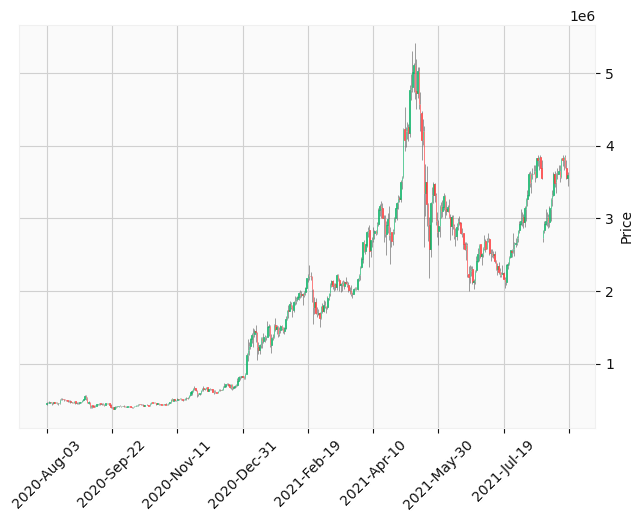

In [514]:
# df_ETH_data
# df_ETH_rolling
mpf.plot(df_ETH_rolling.set_index('datetime'), type='candle', style='yahoo')

## Code Scraps #1

In [ ]:
## Important functions to remember

## 1. Pandas df.index.get_loc[value] is useful to find the location (integer index)
## 2. iloc locates based on "integer indexing", and loc locates based on "element values"


In [ ]:
## Export df_data for future use
from_date = from_date.replace('-', '')
df_BTC_data.to_excel(f"BTC_from_{from_date}_{interval}_{min_interval}.xlsx")
df_ETH_data.to_excel(f"ETH_from_{from_date}_{interval}_{min_interval}.xlsx")
df_XRP_data.to_excel(f"XRP_from_{from_date}_{interval}_{min_interval}.xlsx")        

## Code Scraps #2


In [186]:
def MACD_plot(df, buy_signal, sell_signal, krw_ticker):
    ## Plots and Exports PNG image

    years = mdates.YearLocator()
    months = mdates.MonthLocator()
    days = mdates.DayLocator()

    days_format = DateFormatter("%m-%d-%H")

    xtick_major_N = 5

    f, (ax1, ax3) = plt.subplots(2, 1, figsize=(30, 15))

    # Cutout Previous Data (trim by 20%) --> Gives an Error, why?
    # An error occurs if I trim too much and the sell signal gets lost
#     r, c = df.shape    
#     r_new = int(r * (1 - 0.2)) #trim the first 20%
#     df = df[-r_new:-1]
        
    
#     print('r, c', r, c)
#     print('r_new', r_new)
#     print(df)

    ## Drop buy signal data prior to df dataframe
    df_buy = buy_signal.copy(deep=True)

    for i in buy_signal.datetime:
        if i < df.datetime.iloc[0]:
            index = df_buy[df_buy.datetime == i].index[0]
            df_buy = df_buy.drop(index)

    buy_signal = df_buy.copy(deep=True)

    ## Drop sell signal data prior to df dataframe (what is this???)
    df_sell = sell_signal.copy(deep=True)

    for i in sell_signal.datetime:
        if i < df.datetime.iloc[0]:
            index = df_sell[df_sell.datetime == i].index[0]
            df_sell = df_sell.drop(index)

    sell_signal = df_sell.copy(deep=True)

    ax1.plot(df.datetime, df.Close)
    ax1.plot(df.datetime, df.MA12)
    ax1.plot(df.datetime, df.MA26)
    ax1.legend(labels=['Close', 'MA12', 'MA26'], fontsize='xx-large')
    ax1.set_title(f"{krw_ticker}", fontsize=30)

    # ax1.xaxis.set_major_locator(plt.MaxNLocator(xtick_major_N))
    ax1.grid()
    # plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.set_ylabel('price (KRW)', fontsize=30)
    ax1.tick_params(axis='y', labelsize=15)

    # ax1.set_xlabel('datetime', fontsize = 30)
    ax1.tick_params(axis='x', rotation=30, labelsize=15)

#     ax1.xaxis.set_major_locator(days)
#     ax1.xaxis.set_major_formatter(days_format)

    # ax3.plot(df.datetime, df['dMACD2/dt'])
    
    plotting_factor = get_plotting_factor(df)
    ax3.plot(df.datetime, df['dM/dt']*plotting_factor)
    ax3.plot(df.datetime, df.MACD2)
    ax3.axhline(y=0, lw='2', color='r')

#     ax3.legend(labels=['MACD2_normalized'], fontsize='xx-large')
    ax3.legend(labels=['(dM/dt)_smoothen', 'MACD2_normalized'], fontsize='xx-large')

    ax3.grid()
    ax3.set_xlabel('datetime', fontsize=30)
    ax3.tick_params(axis='x', rotation=30, labelsize=15)

#     ax3.xaxis.set_major_locator(days)
#     ax3.xaxis.set_major_formatter(days_format)

    ax3.set_ylabel('MACD', fontsize=30)
    ax3.tick_params(axis='y', labelsize=15)

    for x_index in buy_signal.datetime:
        ax1.axvline(x=x_index, color='red')
        ax3.axvline(x=x_index, color='red')

    for x_index in sell_signal.datetime:
        ax1.axvline(x=x_index, color='blue')
        ax3.axvline(x=x_index, color='blue')

        # f.tight_layout()

    ## Get current directory and make Datafiles folder (Datafiles_practice for test runs)
#     f_name = get_path(krw_ticker, 'figure')
    
#     save_img = f.savefig(f_name)

    ## Send out to Telegram Bot
#     bot.sendPhoto(chat_id2, photo=open(f_name, 'rb'))

#     plt.close()

    return None

,Open,High,Low,Close,Volume
datetime,,,,,
2021-08-01 04:35:00,"48,027,000.00","48,073,000.00","47,930,000.00","47,984,000.00",1.53
2021-08-01 04:40:00,"47,985,000.00","48,031,000.00","47,957,000.00","48,018,000.00",3.91
2021-08-01 04:45:00,"48,018,000.00","48,018,000.00","47,957,000.00","47,962,000.00",2.17
2021-08-01 04:50:00,"47,962,000.00","47,995,000.00","47,929,000.00","47,936,000.00",5.24
2021-08-01 04:55:00,"47,936,000.00","47,983,000.00","47,917,000.00","47,918,000.00",3.76
...,...,...,...,...,...
2021-08-15 18:10:00,"53,795,000.00","53,896,000.00","53,791,000.00","53,889,000.00",41.00
2021-08-15 18:15:00,"53,889,000.00","53,916,000.00","53,846,000.00","53,855,000.00",23.14
2021-08-15 18:20:00,"53,855,000.00","53,884,000.00","53,761,000.00","53,829,000.00",25.61


In [149]:
## Generally dMdt is much smaller than MACD2, hence the figure gets distorted. Apply a plotting factor to scale (doesn't really work)
def get_plotting_factor(df):    
    
    MACD2_mean = df.MACD2.mean()
    dMdt_mean = df['dM/dt'].mean()
    plotting_factor1 = abs(MACD2_mean/dMdt_mean)    

    MACD_max = abs(np.nanmax(df.MACD2.values))
    MACD_min = abs(np.nanmin(df.MACD2.values))
    MACD_max, MACD_min
    MACD_diff = MACD_max - MACD_min

    dMdt_max = abs(np.nanmax(df['dM/dt'].values))
    dMdt_min = abs(np.nanmin(df['dM/dt'].values))
    dMdt_max, dMdt_min
    dMdt_diff = dMdt_max - dMdt_min

    plotting_factor2 = MACD_diff/dMdt_diff
    
    # Get average of the two
    plotting_factor = (plotting_factor1 + plotting_factor2)/2
      

    return plotting_factor

In [ ]:
## Plot MA & MACD & RSI Data

def chart_plot(df, df_signals):

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10))

    ax1.plot(df.datetime, df.Close)
    ax1.plot(df.datetime, df.MA12)
    ax1.plot(df.datetime, df.MA26)
    ax1.legend(labels=['Close', 'MA12', 'MA26'], fontsize='x-large')
    ax1.set_ylabel('Dollar Price')
    ax1.get_xaxis().set_visible(False)

    # buy_signal = df_BTC_buy
    # sell_signal = df_BTC_sell

    # for x_index in buy_signal.datetime:
    #     ax1.axvline(x=x_index, color='red', linestyle = '--', linewidth = 1)
    #     ax2.axvline(x=x_index, color='red', linestyle = '--', linewidth = 1)

    # for x_index in sell_signal.datetime:
    #     ax1.axvline(x=x_index, color='blue', linestyle = '--', linewidth = 1)    
    #     ax2.axvline(x=x_index, color='blue', linestyle = '--', linewidth = 1)


    ax2.plot(df.datetime, df.MACD)
    ax2.plot(df.datetime, df.Signal)
    ax2.legend(labels=['MACD', 'Signal'], fontsize='x-large')

    ax2y = ax2.twinx() #Create a secondary y-axis
    # ax2y.bar(df.datetime, df['MACD2'], color = 'green', alpha = 0.1)
    ax2y.legend(labels=['MACD - Signal'], fontsize='x-large', loc = 3)
    ax2y.set_ylabel('MACD2')

    ## In order to set zero line at the same point, I need to set ylim in the same range
    ## I need to find out the max of each dataset
    MACD_max = abs(max([df.MACD.max(), df.Signal.max()])) #Find Maximum
    dMdt_max = abs(df['MACD2'].max()) #Find Maximum

    ax2.set_ylim(-1*MACD_max*1.5, MACD_max*1.5) # Set y-axis range so that zero-line overlaps
    ax2y.set_ylim(-1*dMdt_max*1.5, dMdt_max*1.5) # Set y-axis range so that zero-line overlaps


    ax2.set_ylabel('MACD & Signal')
    ax2.axhline(0, color = 'r', linestyle = '-')
    ax2.get_xaxis().set_visible(False)

    ax3.plot(df.datetime, df.RSI)
    ax3.set_ylabel('RSI')
    ax3.set_ylim(0, 100)
    ax3.tick_params(axis='x', rotation=30, labelsize=15)
    ax3.axhline(30, color = 'r', linestyle = '--')
    ax3.axhline(80, color = 'r', linestyle = '--')
    ax3.legend(labels=['RSI'], fontsize='x-large', loc = 0)

    plt.show()
    
    return None

In [95]:
## once I calculate all the signals, I should trim down the first part? --> This would not work for rolling dataset

## Select all columns where MA26 == nan
# df_MACD.loc[pd.isna(df_MACD['MA26']), :]

# ## Select all columns where MA26 == nan
# df_RSI['MA26'].isnull()

# ## Check out the whole column
# df_RSI[df_RSI['MA26'].isnull()]

# ## Get Index
# df_RSI[df_RSI['MA26'].isnull()].index

# ## Remove the rows with nan 
df_RSI.drop(df_RSI[df_RSI['MA26'].isnull()].index, inplace = True)
df_RSI.head(5)

,Open,High,Low,Close,Volume,MA12,MA26,MACD,Signal,MACD2,dMACD/dt,dM/dt,Trade_Signal,Trade_MACD,RSI
datetime,,,,,,,,,,,,,,,
2021-07-05 03:05:00,41199000,41225000,41140000,41185000,4.62,"40,217,904.51","39,850,723.56","278,327.54","19,685.82","258,641.72",-43.31,-47.14,nan,nan,53.30
2021-07-05 03:10:00,41185000,41216000,41099000,41103000,13.80,"40,221,545.14","39,851,218.75","279,151.75","20,884.27","258,267.48",-74.85,-60.21,nan,nan,52.98
2021-07-05 03:15:00,41113000,41177000,41111000,41117000,3.94,"40,225,192.71","39,851,721.15","279,996.35","22,081.09","257,915.26",-70.44,-68.55,nan,nan,53.03
2021-07-05 03:20:00,41154000,41154000,41117000,41144000,1.06,"40,228,862.85","39,852,298.88","280,885.48","23,276.50","257,608.98",-61.26,-71.89,nan,nan,53.12
2021-07-05 03:25:00,41144000,41144000,41097000,41115000,5.34,"40,232,437.50","39,852,743.59","281,714.46","24,470.20","257,244.26",-72.95,-68.84,nan,nan,53.01


## BackTesting

In [72]:
## Back Testing

# df = df_BTC_MACD.copy(deep = True)
df_BTC_signals_backup.head()

,index,datetime,Open,High,Low,Close,Volume,MA12,MA26,MACD,Signal,MACD2,dMACD/dt,dM/dt,Trade_Signal,Trade_MACD,RSI
2,27,2021-08-11 09:00:00,"52,335,000.00","53,500,000.00","52,219,000.00","52,590,000.00","10,943.97","48,867,416.67","44,570,423.08","3,310,815.60","2,808,861.90","501,953.70","-53,187.61","-6,133.55",dMdt_Sell,1.00,100.00
8,33,2021-08-17 09:00:00,"53,863,000.00","54,649,000.00","52,500,000.00","52,660,000.00","9,398.26","52,672,916.67","48,427,576.92","3,267,701.76","3,268,679.08",-977.31,"-209,350.82","-84,684.33",MACD_Sell,2.00,0.00
11,36,2021-08-20 09:00:00,"55,030,000.00","57,910,000.00","54,824,000.00","57,683,000.00","12,560.50","53,873,583.33","50,166,884.62","3,242,647.46","3,207,462.77","35,184.70","162,991.87","9,246.39",dMdt_Buy,5.00,100.00
14,39,2021-08-23 09:00:00,"57,714,000.00","58,726,000.00","57,374,000.00","57,627,000.00","10,945.24","55,130,750.00","51,632,307.69","3,359,669.62","3,279,672.25","79,997.37","-30,880.90","-20,098.68",dMdt_Sell,1.00,0.00
15,40,2021-08-24 09:00:00,"57,627,000.00","57,905,000.00","55,800,000.00","56,134,000.00","16,813.03","55,468,666.67","52,025,653.85","3,193,757.64","3,262,489.33","-68,731.69","-148,729.06","-63,685.36",MACD_Sell,2.00,0.00


In [333]:
## Back testing
# def back_testing(df_signals)


Initial_Balance = 1000000 # Initial Balance
Balance = Initial_Balance

Coin_balance = 0 #Initial Coin Balance
Profit_tracking = [0]

df_balance = pd.DataFrame(columns=['datetime', 'balance', 'Profit'])
df_balance = df_balance.append({'datetime': df_BTC_MACD.datetime.iloc[1], 'balance': Balance, 'Profit': 0}, ignore_index = True)


for i, row in df_BTC_signals.iterrows():
    signal = row.Trade_Signal
    print(row.Trade_Signal)
    if signal == "MACD_Buy" or signal == "dMdt_Buy":
        print(f'buy price at {row.Close}')
        ## 시장가 전량매수
        if Coin_balance == 0:
            Coin_balance = Balance / row.Close
            Profit = (Balance - Initial_Balance)/Balance * 100
            df_balance = df_balance.append({'datetime': row.datetime, 'balance': Balance, 'Profit': Profit}, ignore_index = True)
        
    if signal == "MACD_Sell" or signal == "dMdt_Sell":
        print(f'Sell price at {row.Close}')
        
        ## 시장가 전량매도
        if Coin_balance > 0:
            sell_coin_value = Coin_balance * row.Close
            Balance = sell_coin_value            
            Coin_balance = 0
            
            element['datetime'] = row.datetime
            element['balance'] = Balance
            Profit = (Balance - Initial_Balance)/Balance * 100            
            
            df_balance = df_balance.append({'datetime': row.datetime, 'balance': Balance, 'Profit': Profit}, ignore_index = True)
        
print(Balance)

df_balance

    


dMdt_Sell
Sell price at 10066000.0
MACD_Buy
buy price at 10283000.0
MACD_Sell
Sell price at 11520000.0
dMdt_Buy
buy price at 10870000.0
MACD_Buy
buy price at 7558000.0
dMdt_Sell
Sell price at 8359000.0
MACD_Sell
Sell price at 10457000.0
dMdt_Buy
buy price at 11522000.0
dMdt_Sell
Sell price at 11526000.0
dMdt_Buy
buy price at 11006000.0
MACD_Buy
buy price at 11141000.0
dMdt_Sell
Sell price at 13228000.0
MACD_Sell
Sell price at 13642000.0
dMdt_Buy
buy price at 13696000.0
MACD_Buy
buy price at 12775000.0
MACD_Sell
Sell price at 12014000.0
MACD_Buy
buy price at 12507000.0
dMdt_Sell
Sell price at 15436000.0
MACD_Sell
Sell price at 19225000.0
dMdt_Buy
buy price at 20541000.0
dMdt_Sell
Sell price at 21103000.0
dMdt_Buy
buy price at 20759000.0
MACD_Buy
buy price at 23503000.0
dMdt_Sell
Sell price at 30249000.0
MACD_Sell
Sell price at 37767000.0
dMdt_Buy
buy price at 35500000.0
MACD_Buy
buy price at 39500000.0
dMdt_Sell
Sell price at 64769000.0
MACD_Sell
Sell price at 57456000.0
MACD_Buy
buy pr

,datetime,balance,Profit
0,2020-01-25 18:00:00,1000000,0
1,2020-01-29 04:00:00,1000000,0.00
2,2020-02-16 19:00:00,"1,120,295.63",10.74
3,2020-03-07 21:00:00,"1,120,295.63",10.74
4,2020-04-14 18:00:00,"861,504.25",-16.08
5,2020-06-02 01:00:00,"861,504.25",-16.08
6,2020-06-24 14:00:00,"861,803.33",-16.04
7,2020-07-02 14:00:00,"861,803.33",-16.04
8,2020-07-30 02:00:00,"1,035,792.70",3.46
9,2020-08-31 12:00:00,"1,035,792.70",3.46


(array([737425., 737485., 737546., 737607., 737669., 737730., 737791.,
        737850., 737911., 737972.]),
 <a list of 10 Text major ticklabel objects>)

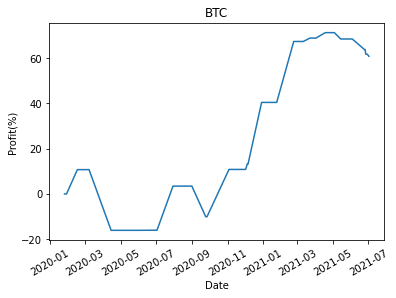

In [378]:
plt.plot(df_balance.datetime, df_balance.Profit)
plt.title('BTC')
plt.ylabel('Profit(%)')
plt.xlabel('Date')
plt.xticks(rotation = 30)